In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def get_samples_per_sec(path):
    all_vals = []
    data = open(path).readlines()
    for line in data:
        if "Train Epoch" in line:
            vals = re.findall("\d+\.\d*\/s,", line)
            vals = [float(v.replace("/s,", "")) for v in vals]
            all_vals.extend(vals)
    return np.mean(all_vals[1:])
def human(v):
    if v < 10 ** 6:
        return str(v)
    elif v > 10**6 and v < 10**9:
        return (str(v/10**6)+"M").replace(".0M", "M")
    elif v > 10**9:
        return (str(v/10**9)+"B").replace(".0B", "B")

def load_results(folder):
    paths = glob(os.path.join(folder, "*.json"))
    results = []
    for path in paths:
        if 'latest' in path:
            continue
        data = json.load(open(path))
        dic = {}
        dic.update(data['metrics'])
        dic['epoch'] = int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]) 
        dic['dataset'] = os.path.basename(path).split("_")[0]
        results.append(dic)
    return pd.DataFrame(results)

def load_config(config):
    jobs = generate_job_defs(config)
    train_jobs = [job for job in jobs if job.params['mode'] == 'train']
    results = []
    for job in train_jobs:
        folder = os.path.dirname(job.output_file)
        paths = glob(os.path.join(folder, "checkpoints", "*.json"))
        samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
        for path in paths:
            if "latest" in path:
                continue
            data = json.load(open(path))
            dic = {
                'model': job.params['model'],
                "pretrain_dataset": job.params['dataset'],
                "downstream_dataset": data['dataset'],
                'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
                "total_epochs": int(job.params["epochs"]),
                "name": job.params["name"],
                "gflops_total": model_profile.loc[job.params["model"]].gflops * int(job.params["epochs"]) * job.params["train_num_samples"],
                "samples_per_sec": samples_per_sec,
                "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
                "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
                "training_time_hours": ((1/samples_per_sec) * int(job.params["epochs"]) * job.params["train_num_samples"]) / 3600,
                "gpus": job.params["nodes"] * 4,
                "total_steps": (int(job.params["epochs"]) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
            }
            dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
            dic.update(job.params)
            dic.update(data['metrics'])
            results.append(dic)
    results = pd.DataFrame(results)
    return results

def load_config_const_lr_cooldown(config):
    jobs = generate_job_defs(config)
    train_jobs = [job for job in jobs if job.params['mode'] == 'train']
    train_jobs = [job for job in train_jobs if job.params['phase'] == 'cooldown']
    results = []
    for job in train_jobs:
        folder = os.path.dirname(job.output_file)
        paths = glob(os.path.join(folder, "checkpoints", "*.json"))
        samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
        for path in paths:
            if "latest" in path:
                continue
            data = json.load(open(path))
            last_epoch = int(job.params["cooldown_checkpoint"]) + int(job.params["epochs_cooldown"])
            dic = {
                'model': job.params['model'],
                "pretrain_dataset": job.params['dataset'],
                "downstream_dataset": data['dataset'],
                'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
                "total_epochs": last_epoch,
                "name": job.params["name"],
                "gflops_total": model_profile.loc[job.params["model"]].gflops * last_epoch * job.params["train_num_samples"],
                "samples_per_sec": samples_per_sec,
                "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
                "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
                "training_time_hours": ((1/samples_per_sec) * last_epoch * job.params["train_num_samples"]) / 3600,
                "gpus": job.params["nodes"] * 4,
                "total_steps": ((last_epoch) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
            }
            dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
            dic.update(job.params)
            dic.update(data['metrics'])
            results.append(dic)
    results = pd.DataFrame(results)
    return results

model_profile = pd.read_csv("/p/project/laionize/jitsev1_juwelsbooster/open_clip_scaling/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [2]:
from scipy.optimize import curve_fit

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.2f} x X^{b:.2f}"


In [10]:
configs = {
    "clip_cosine_lr": "/p/project/laionize/jitsev1_juwelsbooster/open_clip_scaling/configs/config_standardCLIP_scales_compile_whole_span.yaml",
    "clip_const_lr_cooldown": "/p/project/laionize/cherti1/open_clip_scaling/configs/const_lr/config.yaml",
    "mammut_cosine_lr": "/p/project/laionize/jitsev1_juwelsbooster/open_clip_scaling/configs/config_mammut_scales_compile_whole_span.yaml"
}

In [12]:
dfs = []
for k, v in configs.items():
    _load_config = load_config_const_lr_cooldown if "const_lr_cooldown" in k else load_config 
    d = _load_config(v)
    d = d[d.total_epochs==d.epoch]
    #vars = ("name", "epoch", "samples_seen_scale")
    #d = pd.melt(d, id_vars=list(vars), value_vars=["acc1", "image_retrieval_recall@5"])
    #d = d.dropna()
    #d = pd.pivot(d, index=vars, columns="variable", values="value")
    #d = d.reset_index()    
    d["namespace"] = k
    dfs.append(d)
df = pd.concat(dfs)
df["samples_seen_scale_simple"] = df["samples_seen_scale"].apply(lambda s:s.split("_")[0])
df["name_wo_model"] = df.apply(lambda r:f"{r['lr']}_{r['samples_seen_scale_simple']}_{r['global_batch_size']}_{r['warmup']}", axis=1)
df["namespace_model"] = df.apply(lambda r:f"{r['model']}_{r['namespace']}", axis=1)
df["name_wo_lr"] = df.name.apply(lambda n:"_".join([ni for ni in n.split("_") if "lr" not in ni]))
len(df.name_wo_model.unique()), len(df)

/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(185, 1320)

In [13]:
d = df
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d.sort_values(by="acc1")
vars=("samples_seen_scale_simple","namespace", "model")
d = d.drop_duplicates(subset=vars, keep="last")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("namespace_model"),
    values="acc1",
)
#d[d["samples_seen_scale_simple"]=="3B"]
d.T

samples_seen_scale_simple,1.28B,1.28M,12.8B,12.8M,128M,300M,30M,3B,3M
namespace_model,,,,,,,,,
ViT-B-32_clip_const_lr_cooldown,0.60270,NaN,0.68510,NaN,0.10768,NaN,NaN,0.64746,NaN
ViT-B-32_clip_cosine_lr,0.60758,0.01352,NaN,0.11174,0.40396,0.50280,0.21622,0.65288,0.03194
ViT-L-14_clip_cosine_lr,0.73166,0.01662,NaN,0.15592,0.51782,0.62994,0.28626,0.76562,0.02902
ViT-M-32_clip_const_lr_cooldown,0.55902,NaN,0.63916,NaN,0.08978,NaN,NaN,0.60376,NaN
ViT-M-32_clip_cosine_lr,0.57304,0.01396,NaN,0.10504,0.38302,0.47810,0.20074,0.60788,0.03240
ViT-S-16_clip_const_lr_cooldown,0.58170,NaN,0.66210,NaN,0.09390,NaN,NaN,0.62314,NaN
ViT-S-16_clip_cosine_lr,0.59574,0.02000,NaN,0.13388,0.42338,0.50486,0.23700,0.62844,0.04404
ViT-S-32_clip_const_lr_cooldown,0.51138,NaN,0.59442,NaN,0.07572,NaN,NaN,0.55742,NaN
ViT-S-32_clip_cosine_lr,0.53118,0.01304,NaN,0.10208,0.35402,0.43956,0.18664,0.55864,0.03032


In [421]:
d = df
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.namespace.str.contains("const")]
d = d.sort_values(by="acc1")
d = pd.pivot(
    d,
    index="name_wo_lr",
    columns=("lr"),
    values="acc1",
)
#d[d["samples_seen_scale_simple"]=="3B"]
d

lr
name_wo_lr


QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
(2.7241625713305475, -0.15455846400734563)
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
(3.215801112096074, -0.1746991897614706)


/tmp/ipykernel_20931/4002735307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['err'] = (1-d['acc1'])


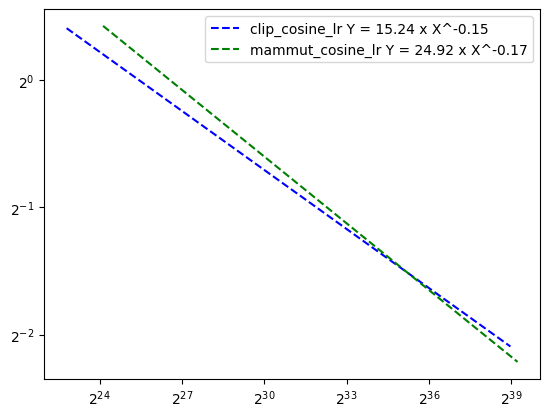

In [423]:
d = df
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d['err'] = (1-d['acc1'])
fig = plt.figure()
colors = ['blue', 'green', 'orange']
for i, ns in enumerate(d.namespace.unique()):
    di = d[d.namespace==ns]
    di = di.sort_values(by="gflops_total")
    X = di.gflops_total.values
    Y = di.err.values
    #coefs, func, eq = curve_fit_powlaw_irreducible(X, Y)
    m = X>=10**11
    Xf = X[m]
    Yf = Y[m]
    #Xf = X
    #Yf = Y
    coefs, func, eq = curve_fit_powlaw_quantile(Xf, Yf, q=0.01)

    print(coefs)
    #eq = f'E = {A:.2f} x G^{B:.6f} + {C:.6f}'
    plt.plot(X, func(X), label=ns + f" {eq}", linestyle='dashed', c=colors[i])
    #plt.scatter(X,Y, c=colors[i], s=5)

#sns.scatterplot(x="gflops_total", y="err", hue='namespace', data=d, fig=fig)
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.legend(bbox_to_anchor=(1,1))